# "Active Learning : Maximal Expected Error Reduction"
> "A programming introduction to Expected Error Reduction Query Strategy in Active Learning with State Vector Machine Model."

- toc: true
- badges: true
- comments: true
- author: Sachin Yadav
- categories: [ActiveLearning]
- image: https://raw.githubusercontent.com/yadav-sachin/blog/master/_notebooks/assets/2022-02-22-maximal-expected-error-reduction-active-learning/active-learning.gif

### Problem with Expected Model Change
- Change in model parameters does not actually correspond to Model performance improvement

The next logical step we take is to directly focus on `Performance metric` , rather than to `Model Change`. So, we will choose the pool instance, which we expect would lead to most model improvement.

### Main Idea 💡

Choose pool instance which Maximizes "generalization" Error Reduction once we add the instance to training set

We sort of use the pool instances as validation set. 


But the pool instances are unlabelled, so we put an estimate to the error and look at `expected error reduction`.
Then we query the instance with minimal expected future error.



In [1]:
# Common Imports 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from matplotlib import rc
import matplotlib
from tqdm.notebook import tqdm

plt.style.use('fivethirtyeight')
rc('animation', html='jshtml')
colors = ['purple','green']

# To copy the models
from copy import deepcopy

# Sklearn Imports
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# Progress helper
from IPython.display import clear_output


### Experiment Configuration

In [2]:
class Config:
    # Dataset Generation
    n_features = 2
    n_classes = 2
    n_samples = 1000
    dataset_random_state = 3
    noise = 0.2

    # Active Learning
    test_frac = 0.2
    init_train_size = 15
    model_random_state = 0
    active_learning_iterations = 50

    # Saved GIF
    fps = 8

    # Base Model
    n_jobs = 1

In [3]:
def get_base_model():
    # return LogisticRegression(random_state = Config.model_random_state, n_jobs = Config.n_jobs)
    return SVC(random_state = Config.model_random_state, probability=True)
    

### 2 Class Dataset

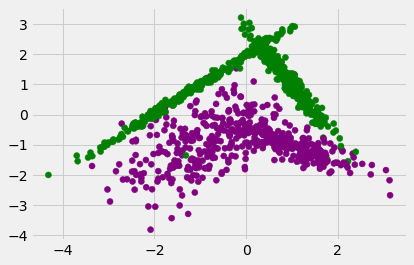

In [4]:
X, y = make_classification(
    n_samples=Config.n_samples,
    n_features=Config.n_features,
    n_informative=Config.n_features,
    n_redundant=0,
    n_classes=Config.n_classes,
    random_state=Config.dataset_random_state,
    shuffle=True,
)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=matplotlib.colors.ListedColormap(colors))

### Full DataFit

In [5]:
model = get_base_model()
model.fit(X, y)

SVC(probability=True, random_state=0)

In [6]:
def plot_decision_surface(X, y, model):
    grid_X1, grid_X2 = np.meshgrid(
        np.linspace(X[:, 0].min() - 0.1, X[:, 0].max() + 0.1, 100),
        np.linspace(X[:, 1].min() - 0.1, X[:, 1].max() + 0.1, 100),
    )

    grid_X = [(x1, x2) for x1, x2 in zip(grid_X1.ravel(), grid_X2.ravel())]

    grid_pred = model.predict(grid_X)

    plt.figure(figsize=(6, 5))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=matplotlib.colors.ListedColormap(colors))
    plt.contourf(grid_X1, grid_X2, grid_pred.reshape(*grid_X1.shape), alpha=0.2, cmap=matplotlib.colors.ListedColormap(colors))

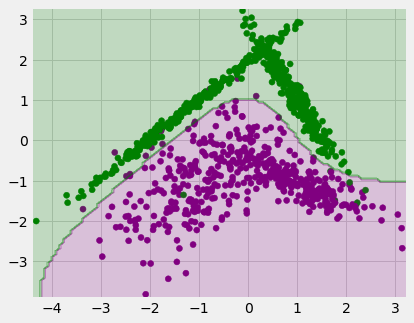

In [7]:
plot_decision_surface(X, y, model)

### Train, Pool, Test Split

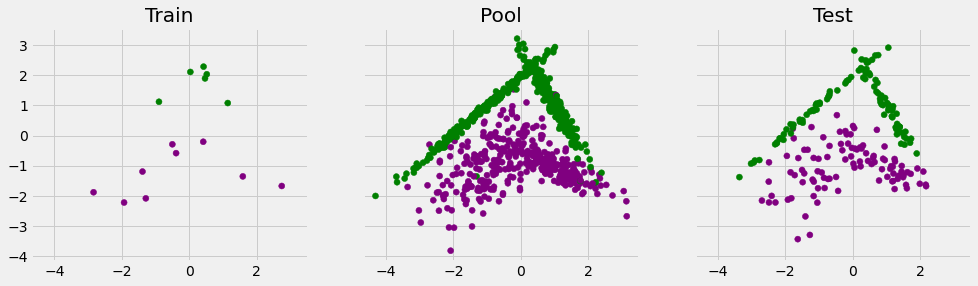

In [8]:
dataset_indices = list(range(len(X)))

train_pool_indices, test_indices = train_test_split(dataset_indices, test_size=Config.test_frac, random_state=0, stratify=y)
train_indices, pool_indices = train_test_split(train_pool_indices, train_size=Config.init_train_size, random_state=0)

indices_list = [train_indices, pool_indices, test_indices]
t_list = ['Train', 'Pool', 'Test']

fig, ax = plt.subplots(1,3,figsize=(15,4), sharex=True, sharey=True)
for i in range(3):
    ax[i].scatter(X[indices_list[i]][:,0], X[indices_list[i]][:,1], c=y[indices_list[i]], cmap=matplotlib.colors.ListedColormap(colors))
    ax[i].set_title(t_list[i])

### Fitting Model on Initial Train Data

In [9]:
AL_model = get_base_model()
AL_model.fit(X[train_indices], y[train_indices])

SVC(probability=True, random_state=0)

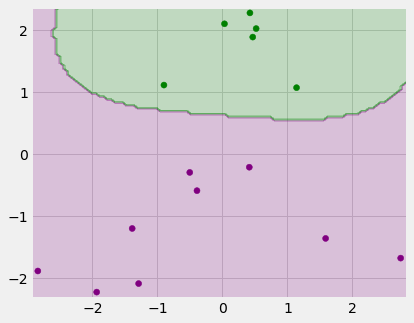

In [10]:
plot_decision_surface(X[train_indices], y[train_indices], AL_model)

## Calculating expected Future Loss
Expected 0/1 Loss is:   

![](./assets/2022-02-22-maximal-expected-error-reduction-active-learning/01-loss-formula.png)

Expected Log-Loss is:   
![](./assets/2022-02-22-maximal-expected-error-reduction-active-learning/log-loss-formula.png)

```
At each iteration:
For each unlabeled pool instance:
    Suppose this instance is labeled and re-train the classifier adding this instance to training set
    Re-infer the labels of remaining pool instances
    Estimate the expected error on remaining pool instances
        - In expected 0/1 loss, we use posterior probability of the most probable class
        - In expected log loss, we use the posterior class distribution
End

Select the instance whose expected error reduction is largest
```

In [11]:
def query_expected_error_reduction(trn_indices, pl_indices, model, loss_type = "01"):
    y_pred_proba = model.predict_proba(X[pl_indices])
    expected_losses = []

    # For each pool instance
    for row_idx, pl_indx in enumerate(pl_indices):

        new_temp_trn_X = X[trn_indices + [pl_indx]] 

        # Add pool instance to the training instance, assuming this class as the label
        new_tmp_pl_indices = pl_indices.copy()
        new_tmp_pl_indices.remove(pl_indx)

        new_temp_pool_X = X[new_tmp_pl_indices]

        expec_loss = 0
        for clss in range(Config.n_classes):
            
            new_temp_trn_y = np.append(y[trn_indices], clss)
            clss_proba = y_pred_proba[row_idx][clss]


            # Train the new model 
            new_temp_model = get_base_model()
            new_temp_model.fit(new_temp_trn_X, new_temp_trn_y)

            # Re-infer the remaining pool indices
            new_tmp_y_pred_proba = new_temp_model.predict_proba(new_temp_pool_X)
            new_tmp_y_pred_log_proba = new_temp_model.predict_log_proba(new_temp_pool_X)
            new_tmp_y_pred = new_temp_model.predict(new_temp_pool_X)
            new_tmp_y_pred_class_proba = new_tmp_y_pred_proba[range(len(new_tmp_pl_indices)), new_tmp_y_pred]

            # Calculate expected loss
            if loss_type == "01":
                loss = np.sum(1 - new_tmp_y_pred_class_proba)
            elif loss_type == "log":
                loss = - np.sum(new_tmp_y_pred_proba * new_tmp_y_pred_log_proba)
            else:
                raise ValueError(f"{loss_type} not identified")

            expec_loss += clss_proba * loss


        expected_losses.append(expec_loss)

    # Select instance with lowest expected error
    return pl_indices[np.argmin(expected_losses)]

### Create test-pool copies for Maximal ERR and Random Strategy

In [12]:
al_train_indices = train_indices.copy()
al_test_indices = test_indices.copy()
al_pool_indices = pool_indices.copy()

random_train_indices = train_indices.copy()
random_test_indices = test_indices.copy()
random_pool_indices = pool_indices.copy()

## Run Active Learning

In [13]:
AL_models = []
random_models = []
AL_added_indices = []
random_added_indices = []

np.random.seed(0)

for active_iteration in tqdm(range(Config.active_learning_iterations)):

    ##### Maximal Expected Error Reduction Strategy ######
    # Fit model
    AL_model = get_base_model()
    AL_model.fit(X[al_train_indices], y[al_train_indices])
    AL_models.append(deepcopy(AL_model))

    # Query a point
    query_idx = query_expected_error_reduction(al_train_indices, al_pool_indices, AL_model, loss_type = "01")
    AL_added_indices.append(query_idx)

    # Add query index to train indices and remove from pool indices
    al_train_indices.append(query_idx)
    al_pool_indices.remove(query_idx)


    ##### Random Strategy #####
    # Fit model
    random_model = get_base_model()
    random_model.fit(X[random_train_indices], y[random_train_indices])
    random_models.append(deepcopy(random_model))

    # Query a point
    query_idx = np.random.choice(random_pool_indices)
    random_added_indices.append(query_idx)

    # Add query index to train indices and remove from pool indices
    random_train_indices.append(query_idx)
    random_pool_indices.remove(query_idx)

  0%|          | 0/50 [00:00<?, ?it/s]

### Plot Accuracy

iteration 49


Text(0, 0.5, 'Accuracy\n(Higher is better)')

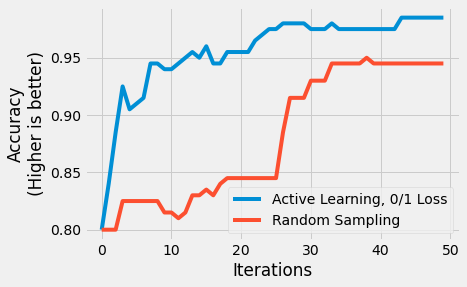

In [21]:
X_test = X[test_indices]
y_test = y[test_indices]
random_scores = []
AL_scores = []
for iteration in range(Config.active_learning_iterations):
    clear_output(wait=True)
    print("iteration", iteration)
    AL_scores.append(accuracy_score(y_test, AL_models[iteration].predict(X_test)))
    random_scores.append(accuracy_score(y_test, random_models[iteration].predict(X_test)))
    
plt.plot(AL_scores, label='Active Learning, 0/1 Loss')
plt.plot(random_scores, label='Random Sampling')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Accuracy\n(Higher is better)')

## Plot Decision Boundaries

In [15]:
grid_X1, grid_X2 = np.meshgrid(
    np.linspace(X[:, 0].min() - 0.1, X[:, 0].max() + 0.1, 100),
    np.linspace(X[:, 1].min() - 0.1, X[:, 1].max() + 0.1, 100),
)

grid_X = [(x1, x2) for x1, x2 in zip(grid_X1.ravel(), grid_X2.ravel())]

In [16]:
X_train, y_train = X[al_train_indices], y[al_train_indices]
X_train_rand, y_train_rand = X[random_train_indices], y[random_train_indices]

In [17]:
def update(i):
    for each in ax:
        each.cla()
        
    AL_grid_preds = AL_models[i].predict(grid_X)
    random_grid_preds = random_models[i].predict(grid_X)
    
    # Active learning
    ax[0].scatter(X_train[:n_train,0], X_train[:n_train,1], c=y_train[:n_train], label='initial_train', alpha=0.2, cmap=matplotlib.colors.ListedColormap(colors))
    ax[0].scatter(X_train[n_train:n_train+i, 0], X_train[n_train:n_train+i, 1], 
                  c=y_train[n_train:n_train+i], label='new_points', cmap=matplotlib.colors.ListedColormap(colors))
    ax[0].contourf(grid_X1, grid_X2, AL_grid_preds.reshape(*grid_X1.shape), alpha=0.2, cmap=matplotlib.colors.ListedColormap(colors))
    ax[0].set_title('New points')
    
    ax[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, label='test_set', cmap=matplotlib.colors.ListedColormap(colors))
    ax[1].contourf(grid_X1, grid_X2, AL_grid_preds.reshape(*grid_X1.shape), alpha=0.2, cmap=matplotlib.colors.ListedColormap(colors))
    ax[1].set_title('Test points')
    ax[0].text(locs[0],locs[1],'Active Learning')
    
    # Random sampling
    ax[2].scatter(X_train_rand[:n_train,0], X_train_rand[:n_train,1], c=y_train_rand[:n_train], label='initial_train', alpha=0.2, cmap=matplotlib.colors.ListedColormap(colors))
    ax[2].scatter(X_train_rand[n_train:n_train+i, 0], X_train_rand[n_train:n_train+i, 1], 
                  c=y_train_rand[n_train:n_train+i], label='new_points', cmap=matplotlib.colors.ListedColormap(colors))
    ax[2].contourf(grid_X1, grid_X2, random_grid_preds.reshape(*grid_X1.shape), alpha=0.2, cmap=matplotlib.colors.ListedColormap(colors))
    ax[2].set_title('New points')
    
    ax[3].scatter(X_test[:, 0], X_test[:, 1], c=y_test, label='test_set', cmap=matplotlib.colors.ListedColormap(colors))
    ax[3].contourf(grid_X1, grid_X2, random_grid_preds.reshape(*grid_X1.shape), alpha=0.2, cmap=matplotlib.colors.ListedColormap(colors))
    ax[3].set_title('Test points')
    ax[2].text(locs[0],locs[1],'Random Sampling')

In [18]:
locs = (2.7, 4)
fig, ax = plt.subplots(2,2,figsize=(12,6), sharex=True, sharey=True)
ax = ax.ravel()
n_train = X_train.shape[0] - Config.active_learning_iterations

anim = FuncAnimation(fig, func=update, frames=range(Config.active_learning_iterations))
plt.close()
anim

In [19]:
mywriter = animation.PillowWriter(fps=Config.fps)
anim.save('./assets/2022-02-22-maximal-expected-error-reduction-active-learning/active-learning.gif',writer=mywriter)

### Major Drawbacks:
- Very expensive: In each active learning iteration, we have to incrementally re-train the model by adding a new pool instance. Therefore in each iterations, we re-train the model $n\_classes \times n\_pool$ times, which is very expensive.

The computational cost is linear to the number of classes and number of pool instances.

In most cases, it is the **most computationally expensive query framework**.

## References:
1. [Active Learning Literature Survey](https://burrsettles.com/pub/settles.activelearning.pdf) by Burr Settles, Section 3.4
2. [YouTube :: Lecture 26](https://www.youtube.com/watch?v=fwHZtqr-uBY&t=3611s&ab_channel=FlorianMarquardt) Active Learning for Network Training: Uncertainty Sampling and other approaches by Florian Marquardt
3. [Original Maximal EER paper](https://axon.cs.byu.edu/Dan/778/papers/Active%20Learning/roy.pdf).Toward Optimal Active Learning through Sampling Estimation of Error Reduction by Roy and McCallum. ICML, 2001. 